# Benchmark for beam deflection

Assumptions made:
- beam is linearly elastic
- fixed-free boundary conditions with a constant distributed load
    - $ @x = 0,\: \nu = 0,\: \frac{\partial \nu}{\partial x} = 0 $
    - $ @x = L,\: \frac{\partial^2 \nu}{\partial x^2}EI = M = 0,\: -\frac{\partial M}{\partial x} = -\frac{\partial^3 \nu}{\partial x^3}EI = 0 $

Goal: simulate the beam deflection, stress, and strain

Constituitive equation: $M = EI \frac{\partial^2 \nu}{\partial x^2} $

where,
$
\nu = deflection\:of\:the\:beam \\
\theta = \frac{\partial \nu}{\partial x} = curvature\:of\:the\:beam \\
x = position\:along\:the\:string \\
EI = rigidity \\
\epsilon = -y\frac{\partial \theta}{\partial x}= strain \\
\sigma = E\epsilon = stress \\
$

Citation(s):

In [55]:
using CombinatorialSpaces, DifferentialEquations, CairoMakie
using MeshIO
using CombinatorialSpaces.DiscreteExteriorCalculus: inv_hodge_star
using CombinatorialSpaces.SimplicialSets: d

# dual subdivision 
function dual(s::EmbeddedDeltaSet2D{O, P}) where {O, P}
  sd = EmbeddedDeltaDualComplex2D{O, eltype(P), P}(s)
  subdivide_duals!(sd, Circumcenter())
  sd
end

dual (generic function with 1 method)

## Define and plot mesh

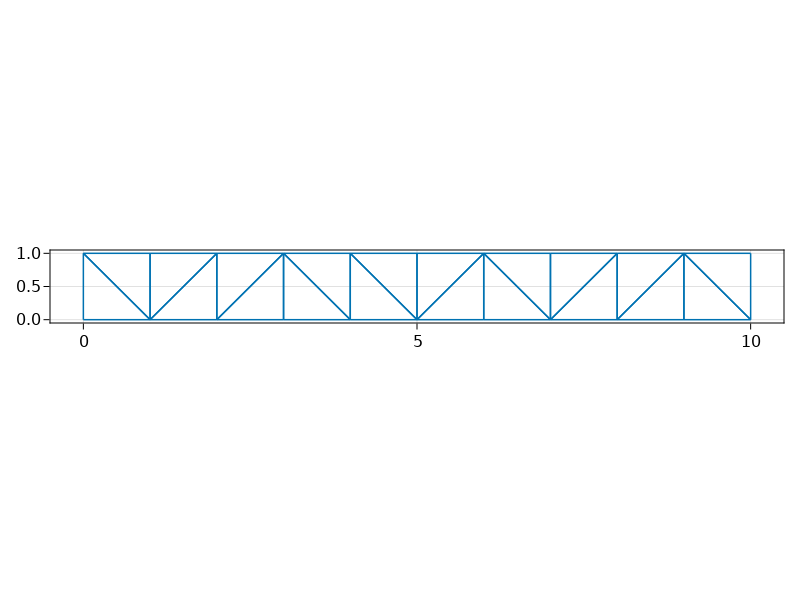

In [79]:
# Define mesh
s = EmbeddedDeltaSet2D("meshes/truss.obj")
sd = dual(s);

# Get boundary masks for BCs #
boundary_e = findall(x -> x != 0, boundary(Val{2},s) * fill(1,ntriangles(s))) # mesh edges
boundary_v = unique(vcat(s[boundary_e,:src],s[boundary_e,:tgt])) # mesh edge vertices

# Define vertices for BC application 
left = filter(x->all((0.0,0.0,0.0) .<= s[x,:point] .<= (0.0,1.0,0.0)), boundary_v) # fixed end

# Plot mesh
fig, ax, ob = wireframe(s)
ax.aspect = AxisAspect(10/1)
fig

In [80]:
# Define the physical constants
q = 900 # prescribed free end point force (N/m)
E = 500 # Elastic Young's modulus (N/m^2)
I = 1/12; # Second moment of area (m^4)
L = 10

x = VForm([p[1] for p in s[:point]])
y = VForm([p[2] for p in s[:point]])

M = DualForm{2}([-((q*L^2)/2) + (q*L*p[1]) - ((q*p[1]^2)/2) for p in s[:point]])

# DualOneForm = ⋆(Val{1}, sd, d(Val{0}, sd, inv_hodge_star(Val{0}, sd, M)));

# θ = inv_hodge_star(Val{1}, sd, DualOneForm)

# ν = inv_hodge_star(Val{0}, sd, dual_derivative(Val{1}, sd, ⋆(Val{1}, sd, θ)))

# ν = inv_hodge_star(Val{0}, sd, M)

41-element Vector{Float64}:
      0.0
     -0.0
 -53550.0
 -53550.0
      0.0
     -0.0
  -7650.0
  -7650.0
      0.0
  -6750.0
     -0.0
      0.0
  -6750.0
      ⋮
     -0.0
  -2250.0
  -2250.0
      0.0
  -1350.0
     -0.0
      0.0
  -1350.0
   -450.0
     -0.0
      0.0
   -450.0

## Add the physics

In [15]:
x_range = 1:length(x)
y_range = (1:length(y)) .+ length(x)

vf(du, u, p, t) = begin
    du .= 
    du[y_range[left]] = 0.0
end

vf (generic function with 1 method)

## Run the simulation(s)

In [17]:
# WITHOUT damping 
tspan = (0.0,1.0)
prob = ODEProblem(vf, M.data, tspan)
sol = solve(prob);


LoadError: MethodError: no method matching ⋆(::Catlab.CSetDataStructures.AttributedCSet{Catlab.Theories.CatDesc{(:V, :E, :Tri, :DualV, :DualE, :DualTri), (:src, :tgt, :∂e0, :∂e1, :∂e2, :D_∂v0, :D_∂v1, :D_∂e0, :D_∂e1, :D_∂e2, :vertex_center, :edge_center, :tri_center), (2, 2, 3, 3, 3, 5, 5, 6, 6, 6, 1, 2, 3), (1, 1, 2, 2, 2, 4, 4, 5, 5, 5, 4, 4, 4)}, Catlab.Theories.AttrDesc{Catlab.Theories.CatDesc{(:V, :E, :Tri, :DualV, :DualE, :DualTri), (:src, :tgt, :∂e0, :∂e1, :∂e2, :D_∂v0, :D_∂v1, :D_∂e0, :D_∂e1, :D_∂e2, :vertex_center, :edge_center, :tri_center), (2, 2, 3, 3, 3, 5, 5, 6, 6, 6, 1, 2, 3), (1, 1, 2, 2, 2, 4, 4, 5, 5, 5, 4, 4, 4)}, (:Orientation, :Real, :Point), (:edge_orientation, :tri_orientation, :D_edge_orientation, :D_tri_orientation, :point, :length, :area, :dual_point, :dual_length, :dual_area), (2, 3, 5, 6, 1, 2, 3, 4, 5, 6), (1, 1, 1, 1, 3, 2, 2, 3, 2, 2)}, Tuple{Bool, Float32, Point{3, Float32}}, (:D_∂e0, :D_∂e1, :D_∂e2, :D_∂v0, :D_∂v1, :src, :tgt, :∂e0, :∂e1, :∂e2), (), NamedTuple{(:V, :E, :Tri, :DualV, :DualE, :DualTri), Tuple{TypedTables.Table{NamedTuple{(:vertex_center, :point), Tuple{Int64, Point{3, Float32}}}, 1, NamedTuple{(:vertex_center, :point), Tuple{Vector{Int64}, Vector{Point{3, Float32}}}}}, TypedTables.Table{NamedTuple{(:src, :tgt, :edge_center, :edge_orientation, :length), Tuple{Int64, Int64, Int64, Bool, Float32}}, 1, NamedTuple{(:src, :tgt, :edge_center, :edge_orientation, :length), Tuple{Vector{Int64}, Vector{Int64}, Vector{Int64}, Vector{Bool}, Vector{Float32}}}}, TypedTables.Table{NamedTuple{(:∂e0, :∂e1, :∂e2, :tri_center, :tri_orientation, :area), Tuple{Int64, Int64, Int64, Int64, Bool, Float32}}, 1, NamedTuple{(:∂e0, :∂e1, :∂e2, :tri_center, :tri_orientation, :area), Tuple{Vector{Int64}, Vector{Int64}, Vector{Int64}, Vector{Int64}, Vector{Bool}, Vector{Float32}}}}, TypedTables.Table{NamedTuple{(:dual_point,), Tuple{Point{3, Float32}}}, 1, NamedTuple{(:dual_point,), Tuple{Vector{Point{3, Float32}}}}}, TypedTables.Table{NamedTuple{(:D_∂v0, :D_∂v1, :D_edge_orientation, :dual_length), Tuple{Int64, Int64, Bool, Float32}}, 1, NamedTuple{(:D_∂v0, :D_∂v1, :D_edge_orientation, :dual_length), Tuple{Vector{Int64}, Vector{Int64}, Vector{Bool}, Vector{Float32}}}}, TypedTables.Table{NamedTuple{(:D_∂e0, :D_∂e1, :D_∂e2, :D_tri_orientation, :dual_area), Tuple{Int64, Int64, Int64, Bool, Float32}}, 1, NamedTuple{(:D_∂e0, :D_∂e1, :D_∂e2, :D_tri_orientation, :dual_area), Tuple{Vector{Int64}, Vector{Int64}, Vector{Int64}, Vector{Bool}, Vector{Float32}}}}}}, NamedTuple{(:D_∂e0, :D_∂e1, :D_∂e2, :D_∂v0, :D_∂v1, :src, :tgt, :∂e0, :∂e1, :∂e2), NTuple{10, Vector{Vector{Int64}}}}}, ::DualForm{2, Float64, Vector{Float64}})
[0mClosest candidates are:
[0m  ⋆(::Catlab.CSetDataStructures.AbstractAttributedCSet, [91m::SimplexForm{n, T, V} where {T, V<:AbstractVector{T}}[39m) where n at C:\Users\mgatlin3\.julia\packages\CombinatorialSpaces\9D0nF\src\DiscreteExteriorCalculus.jl:658

## Plot results

In [ ]:
x_loc = [p[1] for p in s[:point]]

y_loc = [sol1(0)[y_range] sol1(1)[y_range] sol1(2)[y_range] sol1(3)[y_range] sol1(4)[y_range] sol1(5)[y_range] sol1(6)[y_range]] 
Plots.plot(x_loc, y_loc, 
    label = ["t=0s" "t=1s" "t=2s" "t=3s" "t=4s" "t=5s" "t=6s" "t=7s" "t-8s" "t=9s" "t=10s"],
    xlabel="x-coordinate", ylabel="y-coordinate",
#     title="Vibrating String System - Free",
    linewidth = 1.5)


savefig("free_stringVib.png")

## Record results 

In [ ]:
anim = @animate for t ∈ range(0,10.0, length=50)
    x_loc = [p[1] for p in s[:point]]
    y_loc1 = sol1(t)[y_range]
    y_loc3 = sol3(t)[y_range]
    Plots.plot(x_loc, [y_loc1 y_loc3], 
        label = ["free vibration" "damped vibration"],
        ylim = [-5, 5],
        linewidth = 1.5)
end

# gif(anim, "string.gif", fps = 5)

# Exact Solution

In [56]:
M = -((q*L^2)/2) .+ (q.*L.*x) .- ((q.*x.^2)./2);